<a href="https://colab.research.google.com/github/hongsy0113/cose461-NLP-project-choi-hong/blob/main/LSTM%EC%9D%98_%EC%82%AC%EB%B3%B8(age).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soynlp
!pip install konlpy
!pip install tensorflow

from soynlp.normalizer import *
import soynlp

import json
from pandas import json_normalize

import torch
from torch import nn

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# json data 파일들을 google drive에 저장
# google drive 에 있는 파일들을 접근하기 위해 mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. lstm 모델

https://wikidocs.net/44249 
이 내용 거의 따라함

 lstm 모델 따라하기 2 의 아이디어
- 같은 화자의 데이터는 하나의 덩어리로 처리하도록

In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/cose461(2)/age_data_100.csv")

FileNotFoundError: ignored

In [ ]:
df['P_age'] = df['P_age'].astype('int')

In [ ]:
df.head(30)

,index,utterance,P_age
0,"('9f2b0959-7e3d-5e7c-a2a3-18bfb77dcaae', 'P03')",모르도르에 잇네 나 11시쯤 가려구염 아빠 피곤하면 내가 알아서 갈게염 방배 모르도...,0
1,"('32f7c7fe-3b4f-5d5d-bcb1-ffc1b60f6327', 'P02')",네?? 잘먹을게 오늘 육삼냉면먹었는데 생각보다 별로였어 옛날맛이 아닌 아니네 내일 ...,0
2,"('18890137-57e0-58c9-bb94-382304407c5d', 'P02')",흠냐 안논지 너무 오래돼서.. 놀고싶기도 한뎅.. 6시 45분꺼 안되려나 ㅠ.ㅠ? ...,0
3,"('1caad1a9-78bd-5c81-9741-10a0822fa9f1', 'P01')",눈뜨샸나여.... 넹.... 드샸군여.... 뭐먹었어 ㅋㅋㅋㅋ 전 마라여 사골국물 ...,0
4,"('696f7bb8-8a7a-524a-83f7-ad2316c05e4c', 'P01')",야그래서 니몇시도착으로 끊을꺼임?? 더 일찍 몇시??? 새벽4시는 안된다,0
5,"('4183b796-8c1e-52ec-ae84-2a9b94464cd7', 'P02')",가야지 일본 가자 난 올해 일본갈듯 엄마가 오키나와 가자고 난리임 이번에 추석이 황...,0
6,"('1a664bcc-8137-54f0-9316-ccacd0ff18aa', 'P01')",고래성 서폿같이다니는게냥 11~17스 문제이꾸머어엉ㄴ 여행기간이랑 서폿을 겹쳐서잡다...,0
7,"('c92aad36-3f76-5858-82d4-f49ff0fe2e37', 'P02')",#@이모티콘# 다들 드레스코드는 어떻게 됩니까~~ 아 셀카봉 챙겨오실분?!,0
8,"('935e6903-c977-5d40-8b32-4f50561ee49e', 'P01')",일욜에보기루했당 애들이랑 계곡같은데서 맛난거 먹기루해썽 ㅎㅎ 31-4일까지휴간데 3...,0
9,"('70766d76-ec06-55d3-8e7e-9e07593fa3d4', 'P02')",나더 아니 오늘 갈비찜 존니 가고싶다 가면안되니 치료중이니 ㅇㅋㅇㅋ 그럼이제 만나 ...,0


## 데이터 전처리


In [ ]:
from soynlp.normalizer import *
from konlpy.tag import Okt
import re

okt = Okt()

def clean(doc) :

  doc = doc.replace('#@이모티콘#', '이모티콘')

  pattern = '(#@[^#]+#)'
  doc = re.sub(pattern, '', doc)

  new_doc = list()
  doc = okt.pos(doc, norm=True)

  stop_tags = ['Determiner', 'Josa'] #, 'Foreign'] # 'foreign' 은 살려보자. ((이모티콘))으로 통일
  stop_words = ['은', '는', '이', '가', '']
  for text, tag in doc:  

    if tag in stop_tags:
      continue
    
    if tag == 'Foreign':
      text = '((이모티콘))'

    text = re.sub(r'[^ㄱ-ㅣ가-힣?.!~:())\^]+', '', text)  # remove digits. ^, :, ) 는 들어가게
    text = emoticon_normalize(text, num_repeats=2) # remove repeated emoticon. e.g) ㅋㅋㅋㅋ=>ㅋㅋ, ㅠㅠㅠㅠ=>ㅠㅠ
    text = repeat_normalize(text, num_repeats=1) # remove repeated character
    
    if text in stop_words or (tag=='Verb' and len(text)<=1):
      continue
      
    new_doc.append(text)

  return new_doc

In [ ]:
clean("^^ :) #@이모티콘# 💗💗 💗💗")

['^^', ':)', '이모티콘', '((이모티콘))', '((이모티콘))']

In [ ]:
df['sents'] = df['utterance'].apply(clean)
df.head(10)

,index,utterance,P_age,sents
0,"('9f2b0959-7e3d-5e7c-a2a3-18bfb77dcaae', 'P03')",모르도르에 잇네 나 11시쯤 가려구염 아빠 피곤하면 내가 알아서 갈게염 방배 모르도...,0,"[모르, 도르에, 잇네, 나, 시, ((이모티콘)), 가려구, 염, 아빠, 피곤하면..."
1,"('32f7c7fe-3b4f-5d5d-bcb1-ffc1b60f6327', 'P02')",네?? 잘먹을게 오늘 육삼냉면먹었는데 생각보다 별로였어 옛날맛이 아닌 아니네 내일 ...,0,"[네, ??, 잘, 먹을게, 오늘, 육, 삼, 냉면, 먹었는데, 생각, 별로, 였어..."
2,"('18890137-57e0-58c9-bb94-382304407c5d', 'P02')",흠냐 안논지 너무 오래돼서.. 놀고싶기도 한뎅.. 6시 45분꺼 안되려나 ㅠ.ㅠ? ...,0,"[흠, 안, 논지, 너무, 오래, 돼서, .., 놀고싶, 기도, 뎅, .., 시, ..."
3,"('1caad1a9-78bd-5c81-9741-10a0822fa9f1', 'P01')",눈뜨샸나여.... 넹.... 드샸군여.... 뭐먹었어 ㅋㅋㅋㅋ 전 마라여 사골국물 ...,0,"[눈뜨샸나, ...., 넹, ...., 드샸군, ...., 뭐, 먹었어, ㅋㅋㅋ, ..."
4,"('696f7bb8-8a7a-524a-83f7-ad2316c05e4c', 'P01')",야그래서 니몇시도착으로 끊을꺼임?? 더 일찍 몇시??? 새벽4시는 안된다,0,"[야, 그래서, 니, 몇, 시, 도착, 끊을꺼, 임, ??, 더, 일찍, 몇, 시,..."
5,"('4183b796-8c1e-52ec-ae84-2a9b94464cd7', 'P02')",가야지 일본 가자 난 올해 일본갈듯 엄마가 오키나와 가자고 난리임 이번에 추석이 황...,0,"[가야, 일본, 가자, 난, 올해, 일본, 갈듯, 엄마, 오키나와, 가자고, 난리,..."
6,"('1a664bcc-8137-54f0-9316-ccacd0ff18aa', 'P01')",고래성 서폿같이다니는게냥 11~17스 문제이꾸머어엉ㄴ 여행기간이랑 서폿을 겹쳐서잡다...,0,"[고래, 성, 서, 폿, 다니는게, 냥, ~, 스, 문제, 머, 어, 엉, ㄴ, 여..."
7,"('c92aad36-3f76-5858-82d4-f49ff0fe2e37', 'P02')",#@이모티콘# 다들 드레스코드는 어떻게 됩니까~~ 아 셀카봉 챙겨오실분?!,0,"[이모티콘, 다, 드레스코드, 어떻게, 됩니까, ~~, 아, 셀카, 봉, 챙겨오실,..."
8,"('935e6903-c977-5d40-8b32-4f50561ee49e', 'P01')",일욜에보기루했당 애들이랑 계곡같은데서 맛난거 먹기루해썽 ㅎㅎ 31-4일까지휴간데 3...,0,"[일, 욜, 보기, 루, 했당, 애, 들, 계곡, 같은데서, 맛, 거, 먹기, 루해..."
9,"('70766d76-ec06-55d3-8e7e-9e07593fa3d4', 'P02')",나더 아니 오늘 갈비찜 존니 가고싶다 가면안되니 치료중이니 ㅇㅋㅇㅋ 그럼이제 만나 ...,0,"[나더, 아니, 오늘, 갈비찜, 존, 가고싶다, 가면, 안되니, 치료, 중, ㅇㅋㅇ..."


In [ ]:
# 전처리한 데이터프레임 저장
output_file = '/content/gdrive/MyDrive/cose461/my_result_age_data_100.csv'
df.to_csv(output_file, index=False, encoding="utf-8-sig")

데이터 전처리 고려해야 할 점 ㅜㅜ

- ㅋㅋㅋㅋ, ㅇㅇㅇㅇ 어떻게 처리할지. 단순히 여러개 있어도 다 같은 걸로 취급할지 말지
- !, ? 도 마찬가지. soynlp의 textonly 함수를 통해 기호들은 제거가 쉽게 가능할듯 한데. 그럼 정보의 손실이 있을수도
- 이모티콘 이름. 우리 데이터에서 사람 이름은 #@이름# 으로 되어있음. 
- 형태소 분석

### train, test data 만들기 및 정수 인코딩

In [ ]:
# 전처리한 데이터 read_csv로 가져오기
df = pd.read_csv("/content/gdrive/MyDrive/cose461/my_result_age_data_100.csv")

In [ ]:
df.head()

,index,utterance,P_age,sents
0,"('9f2b0959-7e3d-5e7c-a2a3-18bfb77dcaae', 'P03')",모르도르에 잇네 나 11시쯤 가려구염 아빠 피곤하면 내가 알아서 갈게염 방배 모르도...,0,"['모르', '도르에', '잇네', '나', '시', '((이모티콘))', '가려구..."
1,"('32f7c7fe-3b4f-5d5d-bcb1-ffc1b60f6327', 'P02')",네?? 잘먹을게 오늘 육삼냉면먹었는데 생각보다 별로였어 옛날맛이 아닌 아니네 내일 ...,0,"['네', '??', '잘', '먹을게', '오늘', '육', '삼', '냉면', ..."
2,"('18890137-57e0-58c9-bb94-382304407c5d', 'P02')",흠냐 안논지 너무 오래돼서.. 놀고싶기도 한뎅.. 6시 45분꺼 안되려나 ㅠ.ㅠ? ...,0,"['흠', '안', '논지', '너무', '오래', '돼서', '..', '놀고싶'..."
3,"('1caad1a9-78bd-5c81-9741-10a0822fa9f1', 'P01')",눈뜨샸나여.... 넹.... 드샸군여.... 뭐먹었어 ㅋㅋㅋㅋ 전 마라여 사골국물 ...,0,"['눈뜨샸나', '....', '넹', '....', '드샸군', '....', '..."
4,"('696f7bb8-8a7a-524a-83f7-ad2316c05e4c', 'P01')",야그래서 니몇시도착으로 끊을꺼임?? 더 일찍 몇시??? 새벽4시는 안된다,0,"['야', '그래서', '니', '몇', '시', '도착', '끊을꺼', '임', ..."


In [ ]:
X = df['sents']
# y를 one-hot encoding
y = df['P_age'].to_numpy()
y = pd.get_dummies(y).to_numpy()

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(len(tokenizer.word_index))

181683


In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)     # data 적게 할 때는 division by zero 나올수도
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 182211
등장 빈도가 1번 이하인 희귀 단어의 수: 107012
단어 집합에서 희귀 단어의 비율: 58.72971445192662
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.7340183616336695


In [ ]:
# 전체 단어 개수 중 빈도수 threshold 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 75200


In [ ]:
tokenizer = Tokenizer(vocab_size,  filters='[\\].,\'\"\t\n')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
#y_train = np.array(y_train)
#y_test = np.array(y_test)

### 빈 데이터 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

[]
[]


In [ ]:
print(len(X_train))
print(len(y_train))
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print("----After drop empty samples----")
print(len(X_train))
print(len(y_train))

119364
119364
----After drop empty samples----
119364
119364


### 패딩

메시지의 최대 길이 : 967
메시지의 평균 길이 : 22.733463540575205


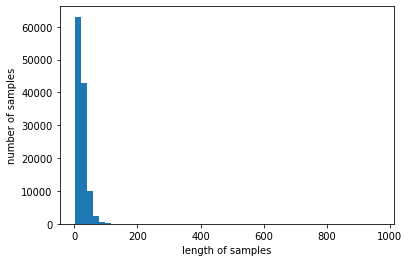

In [ ]:
print('메시지의 최대 길이 :',max(len(l) for l in X_train))
print('메시지의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(80, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.22841057605308


In [ ]:
max_len = 80
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### 모델 정의 및 train

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# best_model 저장해줄 위치. 매번 다르게 해야 됨.
best_model = 'best_model_1118_4.h5'

In [ ]:
with tf.device('/device:GPU:0'):
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
  mc = ModelCheckpoint(best_model, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
# two layer LSTM
with tf.device('/device:GPU:0'):
  embedding_dim2 = 500
  hidden_units1 = 256
  hidden_units2 = 512
  hidden_units3 = 256

  model2 = Sequential()
  model2.add(Embedding(vocab_size, embedding_dim2))
  model2.add(LSTM(hidden_units1,return_sequences = True))
  model2.add(Dropout(0.2))
  model2.add(LSTM(hidden_units2,return_sequences = True))
  model2.add(Dropout(0.2))
  model2.add(LSTM(hidden_units3,return_sequences = False))
  model2.add(Dropout(0.2))
  model2.add(Dense(1024, activation='relu'))
  model2.add(Dense(512, activation='relu'))
  model2.add(Dense(128, activation='relu'))
  model2.add(Dense(3, activation='sigmoid'))

In [ ]:
with tf.device('/device:GPU:0'):
  model2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
  history = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1493/1493 [==============================] - ETA: 0s - loss: 0.8710 - acc: 0.5815
Epoch 00001: val_acc improved from -inf to 0.60512, saving model to best_model_1118_4.h5
1493/1493 [==============================] - 209s 136ms/step - loss: 0.8710 - acc: 0.5815 - val_loss: 0.9036 - val_acc: 0.6051
Epoch 2/15
1493/1493 [==============================] - ETA: 0s - loss: 0.7141 - acc: 0.6901
Epoch 00002: val_acc improved from 0.60512 to 0.65195, saving model to best_model_1118_4.h5
1493/1493 [==============================] - 202s 136ms/step - loss: 0.7141 - acc: 0.6901 - val_loss: 0.8124 - val_acc: 0.6519
Epoch 3/15
1493/1493 [==============================] - ETA: 0s - loss: 0.5669 - acc: 0.7687
Epoch 00003: val_acc did not improve from 0.65195
1493/1493 [==============================] - 198s 133ms/step - loss: 0.5669 - acc: 0.7687 - val_loss: 0.8060 - val_acc: 0.6477
Epoch 4/15
1493/1493 [==============================] - ETA: 0s - loss: 0.4171 - acc: 0.8384
Epoch 00004: val

KeyboardInterrupt: ignored

In [ ]:
# test error
with tf.device('/device:GPU:0'):

  loaded_model = load_model(best_model)
  print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

933/933 [==============================] - 35s 36ms/step - loss: 0.8298 - acc: 0.6468

 테스트 정확도: 0.6468


In [ ]:
# train error
with tf.device('/device:GPU:0'):
  loaded_model = load_model(best_model)
  print("\n train 정확도: %.4f" % (loaded_model.evaluate(X_train, y_train)[1]))

3731/3731 [==============================] - 135s 36ms/step - loss: 0.6493 - acc: 0.7357

 train 정확도: 0.7357


In [ ]:
model2.predict([[1]])

array([[0.49671075, 0.50999576, 0.4934639 ]], dtype=float32)